In [1]:
import $file.^.Magic

import $file.$

In [2]:
Magic.!("pip", "install", "torch==2.4.*")
Magic.!("pip", "install", "tiktoken==0.7.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import $ivy.`dev.scalapy::scalapy-core:0.5.3`

import me.shadaj.scalapy.py
import py.SeqConverters
import py.PyQuote

val torch = py.module("torch")
val tiktoken = py.module("tiktoken")

import $ivy.$
import me.shadaj.scalapy.py
import py.SeqConverters
import py.PyQuote
torch: py.Module = <module 'torch' from '/usr/local/lib/python3.12/site-packages/torch/__init__.py'>
tiktoken: py.Module = <module 'tiktoken' from '/usr/local/lib/python3.12/site-packages/tiktoken/__init__.py'>

In [4]:
case class GPTConfig(
  vocabularySize: Int,
  contextLength: Int,
  embeddingDimension: Int,
  attentionHeadsCount: Int,
  layersCount: Int,
  dropoutRate: Double,
  queryKeyValueBias: Boolean
)

val gptConfig = GPTConfig(
  vocabularySize = 50_257,
  contextLength = 256,
  embeddingDimension = 768,
  attentionHeadsCount = 12,
  layersCount = 12,
  dropoutRate = 0.1,
  queryKeyValueBias = false
)

defined class GPTConfig
gptConfig: GPTConfig = GPTConfig(
  vocabularySize = 50257,
  contextLength = 256,
  embeddingDimension = 768,
  attentionHeadsCount = 12,
  layersCount = 12,
  dropoutRate = 0.1,
  queryKeyValueBias = false
)

In [5]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class MultiHeadAttention(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
type TorchTensor = py.Dynamic
def MultiHeadAttention(
  inputDimension: Int,
  outputDimension: Int,
  dropoutProbability: Double,
  contextLength: Int,
  headsCount: Int,
  queryKeyValueBias: Boolean
): py.Dynamic = {
  assert(outputDimension % headsCount == 0, "Output dimension must be a multiple of heads count")
  val headDimension = outputDimension / headsCount
    
  val init = (self: py.Dynamic) => {
    self.weightsQuery = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
    self.weightsKey = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
    self.weightsValue = torch.nn.Linear(inputDimension, outputDimension, bias = queryKeyValueBias)
    self.outputProjection = torch.nn.Linear(outputDimension, outputDimension)
    self.dropout = torch.nn.Dropout(dropoutProbability)
    self.register_buffer("mask", torch.triu(torch.ones(contextLength, contextLength), diagonal = 1))
      
    val forward = (batchedInputs: TorchTensor) => {
      val (batchesCount, tokensCount, tokenDimension) = batchedInputs.shape.as[(Int, Int, Int)]
      val queries = self.weightsQuery(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val keys = self.weightsKey(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val values = self.weightsValue(batchedInputs)
        .view(batchesCount, tokensCount, headsCount, headDimension)
        .transpose(1, 2)
      val attentionScores = py"$queries @ $keys.transpose(2, 3)"
      attentionScores.masked_fill_(py"${self.mask}.bool()[:$tokensCount, :$tokensCount]", -torch.inf)
      val attentionWeights = self.dropout(torch.softmax(py"$attentionScores / $headDimension**0.5", dim = -1))
      self.outputProjection(
        py"$attentionWeights @ $values"
          .transpose(1, 2)
          .contiguous()
          .view(batchesCount, tokensCount, outputDimension)
      )
    }
    self.forward = forward
  }
  py.Dynamic.global.MultiHeadAttention(init)
}

defined type TorchTensor
defined function MultiHeadAttention

In [6]:
// Workaround to define a class that inherits from a Python class
// Because it mostly uses Python operators, it's implemented fully in Python
py.exec {
  s"""import torch
     |import torch.nn as nn
     |
     |class GELU(nn.Module):
     |  def __init__(self):
     |    super().__init__()
     |
     |  def forward(self, inputs):
     |    return 0.5 * inputs * (
     |      1 + torch.tanh(
     |        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (inputs + 0.044715 * torch.pow(inputs, 3))
     |      )
     |    )
     |""".stripMargin
}
def GELU() = py.Dynamic.global.GELU()

defined function GELU

In [7]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class FeedForward(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def FeedForward(
  embeddingDimension: Int
): py.Dynamic = {
  val init = (self: py.Dynamic) => {
    self.layers = torch.nn.Sequential(
      torch.nn.Linear(embeddingDimension, 4 * embeddingDimension),
      GELU(),
      torch.nn.Linear(4 * embeddingDimension, embeddingDimension)
    )
      
    val forward = (inputs: TorchTensor) => self.layers(inputs)
    self.forward = forward
  }
  py.Dynamic.global.FeedForward(init)
}

defined function FeedForward

In [8]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class NormalizationLayer(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def NormalizationLayer(
  embeddingDimension: Int
): py.Dynamic = {
  val epsilon = 1e-5
  val init = (self: py.Dynamic) => {
    self.scale = torch.nn.Parameter(torch.ones(embeddingDimension))
    self.shift = torch.nn.Parameter(torch.zeros(embeddingDimension))
      
    val forward = (inputs: TorchTensor) => {
      val mean = inputs.mean(dim = -1, keepdim = true)
      val variance = inputs.`var`(dim = -1, keepdim = true, unbiased = false)
      val normalizedInputs = py"($inputs - $mean) / torch.sqrt($variance + $epsilon)"
      py"${self.scale} * $normalizedInputs + ${self.shift}"
    }
    self.forward = forward
  }
  py.Dynamic.global.NormalizationLayer(init)
}

defined function NormalizationLayer

In [9]:
import scala.util.chaining._

py.exec {
  s"""import torch.nn as nn
     |
     |class TransformerBlock(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
def TransformerBlock(
  config: GPTConfig
): py.Dynamic = {
  val init = (self: py.Dynamic) => {
    self.multiHeadAttention = MultiHeadAttention(
      inputDimension = config.embeddingDimension,
      outputDimension = config.embeddingDimension,
      dropoutProbability = config.dropoutRate,
      contextLength = config.contextLength,
      headsCount = config.attentionHeadsCount,
      queryKeyValueBias = config.queryKeyValueBias
    )
    self.feedForward = FeedForward(config.embeddingDimension)
    self.normalization1 = NormalizationLayer(config.embeddingDimension)
    self.normalization2 = NormalizationLayer(config.embeddingDimension)
    self.dropoutShortcut = torch.nn.Dropout(config.dropoutRate)
    
    val forward = (inputs: TorchTensor) => {
      val shortcut = inputs
      val newShortcut = inputs
        .pipe(self.normalization1(_))
        .pipe(self.multiHeadAttention(_))
        .pipe(self.dropoutShortcut(_))
        .pipe(o => py"$o + $shortcut")
      newShortcut
        .pipe(self.normalization2(_))
        .pipe(self.feedForward(_))
        .pipe(self.dropoutShortcut(_))
        .pipe(o => py"$o + $newShortcut")
    }
    self.forward = forward
  }
  py.Dynamic.global.TransformerBlock(init)
}

import scala.util.chaining._
defined function TransformerBlock

In [10]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""import torch.nn as nn
     |
     |class GPTModel(nn.Module):
     |  def __init__(self, init):
     |    super().__init__()
     |    init(self)
     |""".stripMargin
}
type Model = py.Dynamic
def GPTModel(
  config: GPTConfig
): Model = {
  val transformerBlocks = Seq.fill(config.layersCount)(TransformerBlock(config))
  val init = (self: py.Dynamic) => {
    self.tokenEmbeddingLayer = torch.nn.Embedding(config.vocabularySize, config.embeddingDimension)
    self.positionEmbeddingLayer = torch.nn.Embedding(config.contextLength, config.embeddingDimension)
    self.dropoutEmbeddingLayer = torch.nn.Dropout(config.dropoutRate)
    self.transformerBlocksLayer = py"nn.Sequential(*${transformerBlocks.toPythonProxy})"
    self.finalNormalizationLayer = NormalizationLayer(config.embeddingDimension)
    self.outputLayer = torch.nn.Linear(config.embeddingDimension, config.vocabularySize, bias = false)
      
    val forward = (batchedInputs: TorchTensor) => {
      val (_, sequenceLength) = batchedInputs.shape.as[(Int, Int)]
      val tokenEmbeddings = self.tokenEmbeddingLayer(batchedInputs)
      val positionEmbeddings = self.positionEmbeddingLayer(torch.arange(sequenceLength, device = batchedInputs.device))
      py"$tokenEmbeddings + $positionEmbeddings"
        .pipe(self.dropoutEmbeddingLayer(_))
        .pipe(self.transformerBlocksLayer(_))
        .pipe(self.finalNormalizationLayer(_))
        .pipe(self.outputLayer(_))
    }
    self.forward = forward
  }
  py.Dynamic.global.GPTModel(init)
}

defined type Model
defined function GPTModel

In [11]:
torch.manual_seed(123)
val model = GPTModel(gptConfig)
println(s"Total trainable parameters: ${py"sum(p.numel() for p in $model.parameters())"}")
model.eval()

Total trainable parameters: 162419712


res11_0: py.Dynamic = <torch._C.Generator object at 0xffff64b4a7b0>
model: Model = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(256, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=False)
        (weightsKey): Linear(in_features=768, out_features=768, bias=False)
        (weightsValue): Linear(in_features=768, out_features=768, bias=False)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): Norm

In [12]:
def generateTextSimple(
  model: Model,
  maxNewTokens: Int,
  contextLength: Int
)(
  encodedInput: TorchTensor
): TorchTensor =
  LazyList.iterate(encodedInput) { currentEncodedOutput =>
    val croppedInput = py"$currentEncodedOutput[:, -$contextLength:]"
    val logits = py.`with`(torch.no_grad()) { _ =>
      model(croppedInput)
    }
    py"$logits[:, -1, :]"
      .pipe(torch.softmax(_, dim = -1))
      .pipe(torch.argmax(_, dim = -1, keepdim = true))
      .pipe(nextEncodedOutput => torch.cat((currentEncodedOutput, nextEncodedOutput), dim = 1))
  }.drop(maxNewTokens).head

defined function generateTextSimple

In [13]:
type Tokenizer = py.Dynamic
def textToTokenIds(
  text: String, 
  tokenizer: Tokenizer
): TorchTensor = {
  val allowedSpecial = py.Dynamic.global.set(Seq("<|endoftext|>").toPythonProxy)
  val encodedText = tokenizer.encode(text, allowed_special = allowedSpecial)
  torch.tensor(encodedText).unsqueeze(0)
}
    
def tokenIdsToText(
  tokenIds: TorchTensor, 
  tokenizer: Tokenizer
): String =
  tokenizer.decode(tokenIds.squeeze(0).tolist()).as[String]

defined type Tokenizer
defined function textToTokenIds
defined function tokenIdsToText

In [14]:
val tokenizer = tiktoken.get_encoding("gpt2")
val exampleText = "Every effort moves you"
val outputTextIds = generateTextSimple(
  model = model, 
  maxNewTokens = 10, 
  contextLength = gptConfig.contextLength
)(
  encodedInput = textToTokenIds(exampleText, tokenizer)
)
val decodedOutputText = tokenIdsToText(outputTextIds, tokenizer)
println(s"Output text: $decodedOutputText")

Output text: Every effort moves you impressed Arafootball beggreetings prev1980 reproduction Bang Whis


tokenizer: py.Dynamic = <Encoding 'gpt2'>
exampleText: String = "Every effort moves you"
outputTextIds: TorchTensor = tensor([[ 6109,  3626,  6100,   345, 12617, 30574, 15914, 44887, 46648,  8654,
         23664, 20728,  9801, 28424]])
decodedOutputText: String = "Every effort moves you impressed Arafootball beggreetings prev1980 reproduction Bang Whis"

In [15]:
import scala.io.Source

val filePath = "data/the_verdict.txt"
val textData = Source.fromFile(filePath).mkString

import scala.io.Source
filePath: String = "data/the_verdict.txt"
textData: String = """I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, w

In [16]:
val totalCharacters = textData.length
val totalTokens = tokenizer.encode(textData).as[Vector[Int]].length
println(s"Characters: $totalCharacters")
println(s"Tokens: $totalTokens")

Characters: 20479
Tokens: 5145


totalCharacters: Int = 20479
totalTokens: Int = 5145

In [17]:
val trainingRatio = 0.9
val splitIndex = (totalCharacters * trainingRatio).toInt
val (trainingData, validationData) = textData.splitAt(splitIndex)
println(s"Training data size: ${trainingData.size}")
println(s"Validation data size: ${validationData.size}")

Training data size: 18431
Validation data size: 2048


trainingRatio: Double = 0.9
splitIndex: Int = 18431
trainingData: String = """I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)

"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it's going to send the value of my picture 'way up; but I don't think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing's lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-dancers" to say, with tears

In [18]:
// Workaround to define a class that inherits from a Python class
py.exec {
  s"""from torch.utils.data import Dataset
     |
     |class GPTDatasetV1(Dataset):
     |  def __init__(self, len, getItem):
     |    self.len = len
     |    self.getItem = getItem
     |  
     |  def __len__(self):
     |    return self.len()
     |
     |  def __getitem__(self, index):
     |    return self.getItem(index)
     |""".stripMargin
}
def GPTDatasetV1(
  text: String,
  tokenizer: Tokenizer,
  maxLength: Int,
  step: Int
): py.Dynamic = {
  val tokens = tokenizer.encode(text).as[Vector[Int]]
  val (inputTokens, outputTokens) = (0 until (tokens.length - maxLength) by step).foldLeft(
    (
      Vector.empty[TorchTensor], 
      Vector.empty[TorchTensor]
    )
  ) {
    case ((inputTokens, outputTokens), i) =>
      val inputChunk = tokens.slice(i, i + maxLength)
      val outputChunk = tokens.slice(i + 1, i + 1 + maxLength)
      (
       inputTokens :+ torch.tensor(inputChunk.toPythonProxy), 
       outputTokens :+ torch.tensor(outputChunk.toPythonProxy)
      )
  }
  val len = () => inputTokens.length
  val getItem = (index: Int) => (inputTokens(index), outputTokens(index))
  py.Dynamic.global.GPTDatasetV1(len, getItem)
}

type DataLoader = py.Dynamic
def createDataLoaderV1(
  text: String, 
  batchSize: Int = 4,
  maxLength: Int = 256,                       
  step: Int = 128, 
  shuffle: Boolean = true, 
  dropLast: Boolean = true,
  numWorkers: Int = 0 
): DataLoader = {
  val tokenizer = tiktoken.get_encoding("gpt2")
  val dataset = GPTDatasetV1(text, tokenizer, maxLength, step)
  torch.utils.data.DataLoader(
    dataset,
    batch_size = batchSize,
    shuffle = shuffle,
    drop_last = dropLast,
    num_workers = numWorkers
  )
}

defined function GPTDatasetV1
defined type DataLoader
defined function createDataLoaderV1

In [19]:
val trainingLoader = createDataLoaderV1(
  text = trainingData, 
  batchSize  = 2, 
  maxLength = gptConfig.contextLength,                       
  step = gptConfig.contextLength, 
  shuffle = true, 
  dropLast = true,
  numWorkers = 0 
)
val validationLoader = createDataLoaderV1(
  text = validationData, 
  batchSize  = 2, 
  maxLength = gptConfig.contextLength,                       
  step = gptConfig.contextLength, 
  shuffle = false, 
  dropLast = false,
  numWorkers = 0 
)

def printBatchShapes(loader: DataLoader) = {
  val loaderBatches = py"[batch for batch in $loader]".as[Seq[Seq[TorchTensor]]]
  loaderBatches.zipWithIndex.foreach { case (Seq(inputBatch, targetBatch), i) =>
    println(s"Batch $i: ${inputBatch.shape} -> ${targetBatch.shape}")
  }
}
println("Training loader batches")
printBatchShapes(trainingLoader)
println()
println("Validation loader batches")
printBatchShapes(validationLoader)

Training loader batches
Batch 0: torch.Size([2, 256]) -> torch.Size([2, 256])
Batch 1: torch.Size([2, 256]) -> torch.Size([2, 256])
Batch 2: torch.Size([2, 256]) -> torch.Size([2, 256])
Batch 3: torch.Size([2, 256]) -> torch.Size([2, 256])
Batch 4: torch.Size([2, 256]) -> torch.Size([2, 256])
Batch 5: torch.Size([2, 256]) -> torch.Size([2, 256])
Batch 6: torch.Size([2, 256]) -> torch.Size([2, 256])
Batch 7: torch.Size([2, 256]) -> torch.Size([2, 256])
Batch 8: torch.Size([2, 256]) -> torch.Size([2, 256])

Validation loader batches
Batch 0: torch.Size([2, 256]) -> torch.Size([2, 256])


trainingLoader: DataLoader = <torch.utils.data.dataloader.DataLoader object at 0xffff3f735ca0>
validationLoader: DataLoader = <torch.utils.data.dataloader.DataLoader object at 0xffff3f711d30>
defined function printBatchShapes

In [20]:
type Device = py.Dynamic
def calculateBatchLoss(
  model: Model,
  device: Device
)(
  inputBatch: TorchTensor,
  targetBatch: TorchTensor
): TorchTensor = {
  val outputs = model(inputBatch.to(device))
  torch.nn.functional.cross_entropy(outputs.flatten(0, 1), targetBatch.flatten())
}

defined type Device
defined function calculateBatchLoss

In [21]:
def calculateDataLoaderLoss(
  model: Model,
  device: Device
)(
  dataLoader: DataLoader,
  batchesCountOpt: Option[Int] = None
): Double = { 
  val batchesCount = batchesCountOpt match {
    case Some(batchesCount) => batchesCount
    case None => py"len($dataLoader)".as[Int]
  }
  assert(batchesCount > 0, "There were no batches to process")
  var totalLoss = 0.0
  val batchesIterator = py"iter($dataLoader)"
  var currentBatch = py"next($batchesIterator, None)"
  var currentBatchIndex = 0
  while (
    currentBatchIndex < batchesCount && 
    currentBatch != py.Dynamic.global.None
  ) {
    py.local {
      val Seq(inputBatch, targetBatch) = currentBatch.as[Seq[TorchTensor]]
      totalLoss += calculateBatchLoss(model, device)(inputBatch, targetBatch).item().as[Double]
    }
    currentBatch = py"next($batchesIterator, None)"
    currentBatchIndex += 1
  }
  totalLoss / batchesCount
}

defined function calculateDataLoaderLoss

In [22]:
val device = torch.device(if (torch.cuda.is_available().as[Boolean]) "cuda" else "cpu")
model.to(device)
py.`with`(torch.no_grad()) { _ =>
  println(s"Calculating training loss...")
  val trainingLoss = calculateDataLoaderLoss(model, device)(trainingLoader)
  println(s"Training loss: $trainingLoss")
  println(s"Calculating validation loss...")
  val validationLoss = calculateDataLoaderLoss(model, device)(validationLoader)
  println(s"Validation loss: $validationLoss")
}

Calculating training loss...
Training loss: 11.009115431043837
Calculating validation loss...
Validation loss: 11.044095993041992


device: py.Dynamic = cpu
res22_1: py.Dynamic = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(256, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=False)
        (weightsKey): Linear(in_features=768, out_features=768, bias=False)
        (weightsValue): Linear(in_features=768, out_features=768, bias=False)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): NormalizationLayer()
      (normalizatio

In [23]:
case class Loss(
  trainingLoss: Double,
  validationLoss: Double
)

case class TrainingStep(
  loss: Loss,
  tokensSeen: Long
)

class ModelEvaluator(
  device: Device,
  trainingLoader: DataLoader,
  validationLoader: DataLoader,
  evaluationEpochsCount: Int,
  evaluationFrequencySteps: Int
) {

  def evaluateCond(currentStep: Int)(model: Model): Option[Loss] =
    Option.when(currentStep % evaluationFrequencySteps == 0) {
      println(s"Step $currentStep")
      evaluate(model)
    }
    
  def evaluate(model: Model): Loss = {
    model.eval()
    py.`with`(torch.no_grad()) { _ =>
      val trainingLoss = calculateDataLoaderLoss(model, device)(trainingLoader, batchesCountOpt = Some(evaluationEpochsCount))
      val validationLoss = calculateDataLoaderLoss(model, device)(validationLoader, batchesCountOpt = Some(evaluationEpochsCount))
      println(
        s"""- training loss: $trainingLoss
           |- validation loss: $validationLoss""".stripMargin
      )
      model.train()
      Loss(trainingLoss, validationLoss)
    }
  }
}

class SampleGenerator(
  device: Device,
  tokenizer: Tokenizer,
  text: String,
  contextLength: Int
) {

  def generateAndPrintSample(model: Model): Unit = {
    model.eval()
    val encodedText = textToTokenIds(text, tokenizer)
    py.`with`(torch.no_grad()) { _ =>
      val tokenIds = generateTextSimple(
        model = model, 
        maxNewTokens = 50, 
        contextLength = contextLength
      )(encodedText)
      val decodedText = tokenIdsToText(tokenIds, tokenizer).replace("\n", " ")
      println(s"Sample text for '$text':\n'$decodedText'")
      model.train()
    }
  }
}

type Optimizer = py.Dynamic
def trainModelSimple(
  model: Model,
  device: Device,
  trainingLoader: DataLoader,
  validationLoader: DataLoader,
  optimizer: Optimizer,
  epochsCount: Int,
  modelEvaluator: ModelEvaluator,
  sampleGenerator: SampleGenerator
): List[TrainingStep] = {
  var stepsCount = 0
  var tokensSeen = 0L
  val losses =
    for {
      epoch <- 1 to epochsCount
    } yield py.local {
      println(s"=> Epoch $epoch")
      model.train()
      val batchesIterator = py"iter($trainingLoader)"
      val losses = LazyList
        .continually(py"next($batchesIterator, None)")
        .takeWhile(_ != py.Dynamic.global.None)
        .map(_.as[Seq[TorchTensor]])
        .map { batch =>
          py.local {
            val Seq(inputBatch, targetBatch) = batch
            optimizer.zero_grad()
            val loss = calculateBatchLoss(model, device)(inputBatch, targetBatch)
            loss.backward()
            optimizer.step()
            stepsCount += 1
            tokensSeen += inputBatch.numel().as[Long]
            modelEvaluator.evaluateCond(stepsCount)(model).map { loss =>
              TrainingStep(loss, tokensSeen)
            }
          }
        }.flatten.toList
      sampleGenerator.generateAndPrintSample(model)
      losses
    }
  losses.toList.flatten
}

defined class Loss
defined class TrainingStep
defined class ModelEvaluator
defined class SampleGenerator
defined type Optimizer
defined function trainModelSimple

In [24]:
torch.manual_seed(123)
val model = GPTModel(gptConfig)
model.to(device)
val optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay = 0.1)
val epochsCount = 10
val modelEvaluator = new ModelEvaluator(device, trainingLoader, validationLoader, evaluationEpochsCount = 5, evaluationFrequencySteps = 5)
val sampleGenerator = new SampleGenerator(device, tokenizer, text = "Every effort moves you", contextLength = gptConfig.contextLength)

res24_0: py.Dynamic = <torch._C.Generator object at 0xffff64b4a7b0>
model: Model = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(256, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=False)
        (weightsKey): Linear(in_features=768, out_features=768, bias=False)
        (weightsValue): Linear(in_features=768, out_features=768, bias=False)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): Norm

In [25]:
val trainingSteps = trainModelSimple(model, device, trainingLoader, validationLoader, optimizer, epochsCount, modelEvaluator, sampleGenerator)

=> Epoch 1
Step 5
- training loss: 8.465807342529297
- validation loss: 1.7353384017944335
Sample text for 'Every effort moves you':
'Every effort moves you,,,,,,,,,,,,,,.                                   '
=> Epoch 2
Step 10
- training loss: 7.041613388061523
- validation loss: 1.451545238494873
Step 15
- training loss: 6.1582635879516605
- validation loss: 1.326794147491455
Sample text for 'Every effort moves you':
'Every effort moves you, and,,,,,,,,,, and, and,,,, and,,, and,, and,, and,,,, and,, and,,,,, and,,,,, and'
=> Epoch 3
Step 20
- training loss: 5.621779441833496
- validation loss: 1.3087495803833007
Step 25
- training loss: 5.312926006317139
- validation loss: 1.277871799468994
Sample text for 'Every effort moves you':
'Every effort moves you know to           "I, and he was, and, and I had the his, and I had the the of the, and I had been, and he was, and, and I had'
=> Epoch 4
Step 30
- training loss: 4.527096509933472
- validation loss: 1.2614811897277831
Step 35
- tr

trainingSteps: List[TrainingStep] = List(
  TrainingStep(
    loss = Loss(
      trainingLoss = 8.465807342529297,
      validationLoss = 1.7353384017944335
    ),
    tokensSeen = 2560L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 7.041613388061523,
      validationLoss = 1.451545238494873
    ),
    tokensSeen = 5120L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 6.1582635879516605,
      validationLoss = 1.326794147491455
    ),
    tokensSeen = 7680L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 5.621779441833496,
      validationLoss = 1.3087495803833007
    ),
    tokensSeen = 10240L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 5.312926006317139,
      validationLoss = 1.277871799468994
    ),
    tokensSeen = 12800L
  ),
  TrainingStep(
    loss = Loss(
      trainingLoss = 4.527096509933472,
...

In [26]:
Magic.!("pip", "install", "matplotlib==3.9.*")


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [27]:
import $file.^.DisplaySupport

Compiling /workspace/DisplaySupport.sc


import $file.$

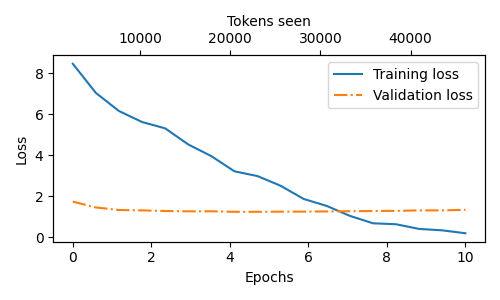

plot: py.Module = <module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/site-packages/matplotlib/pyplot.py'>
ticker: py.Module = <module 'matplotlib.ticker' from '/usr/local/lib/python3.12/site-packages/matplotlib/ticker.py'>

In [28]:
val plot = py.module("matplotlib.pyplot")
val ticker = py.module("matplotlib.ticker")

try {
  type Figure = py.Dynamic
  type Axis = py.Dynamic
    
  val (tokensSeen, trainingLoss, validationLoss) = trainingSteps.map {
    case TrainingStep(Loss(trainingLoss, validationLoss), tokensSeen) => (tokensSeen, trainingLoss, validationLoss)
  }.unzip3
  val epochs = torch.linspace(0, epochsCount, tokensSeen.length)
  val (figure, axis1) = plot.subplots(figsize = (5, 3)).as[(Figure, Axis)]
  axis1.plot(epochs, trainingLoss.toPythonProxy, label = "Training loss")
  axis1.plot(epochs, validationLoss.toPythonProxy, linestyle = "-.", label = "Validation loss")
  axis1.set_xlabel("Epochs")
  axis1.set_ylabel("Loss")
  axis1.legend(loc = "upper right")
  axis1.xaxis.set_major_locator(ticker.MaxNLocator(integer = true))
  val axis2 = axis1.twiny()
  axis2.plot(tokensSeen.toPythonProxy, trainingLoss.toPythonProxy, alpha = 0)
  axis2.set_xlabel("Tokens seen")
  figure.tight_layout()
  DisplaySupport.showPlot(plot)
} catch {
  case e: py.PythonException =>
    println("(!) If the exception below says 'Numpy is not available', restart the Jupyter kernel. It's an issue with Matplotlib in Jupyter.\n")
    throw e
}

In [29]:
model.eval()

res29: py.Dynamic = GPTModel(
  (tokenEmbeddingLayer): Embedding(50257, 768)
  (positionEmbeddingLayer): Embedding(256, 768)
  (dropoutEmbeddingLayer): Dropout(p=0.1, inplace=False)
  (transformerBlocksLayer): Sequential(
    (0): TransformerBlock(
      (multiHeadAttention): MultiHeadAttention(
        (weightsQuery): Linear(in_features=768, out_features=768, bias=False)
        (weightsKey): Linear(in_features=768, out_features=768, bias=False)
        (weightsValue): Linear(in_features=768, out_features=768, bias=False)
        (outputProjection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedForward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): NormalizationLayer()
      (normalization2): NormalizationLayer()
 

In [30]:
def generateText(
  model: Model,
  maxNewTokens: Int,
  contextLength: Int,
  temperature: Double,
  topK: Option[Int] = None
)(
  encodedInput: TorchTensor
): TorchTensor =
  LazyList.iterate(encodedInput) { currentEncodedOutput =>
    val croppedInput = py"$currentEncodedOutput[:, -$contextLength:]"
    val logits = py.`with`(torch.no_grad()) { _ =>
      model(croppedInput)
    }
    py"$logits[:, -1, :]"
      .pipe { logits =>
        topK match {
          case Some(topK) =>
            val (topLogits, _) = torch.topk(logits, topK).as[(TorchTensor, TorchTensor)]
            val minValue = py"$topLogits[:, -1]"
            torch.where(
              py"$logits < $minValue",
              torch.tensor(-torch.inf).to(logits.device),
              logits
            )
          case None => logits
        }
      }
      .pipe { logits =>
        if (temperature > 0)
          logits
            .pipe(logits => py"$logits / $temperature")
            .pipe(torch.softmax(_, dim = -1))
            .pipe(torch.multinomial(_, num_samples = 1))
        else 
          logits
            .pipe(torch.argmax(_, dim = -1, keepdim = true))
      }
      .pipe(nextEncodedOutput => torch.cat((currentEncodedOutput, nextEncodedOutput), dim = 1))
  }.drop(maxNewTokens).head

defined function generateText

In [31]:
torch.manual_seed(123)
val exampleText = "Every effort moves you"
val outputTextIds = generateText(
  model = model, 
  maxNewTokens = 15,
  contextLength = gptConfig.contextLength,
  temperature = 1.4,
  topK = Some(25)
)(
  encodedInput = textToTokenIds(exampleText, tokenizer)
)
val decodedOutputText = tokenIdsToText(outputTextIds, tokenizer)
println(s"Output text: $decodedOutputText")

Output text: Every effort moves you?" I meant to surprise, for he answered with a deprecating laugh


res31_0: py.Dynamic = <torch._C.Generator object at 0xffff64b4a7b0>
exampleText: String = "Every effort moves you"
outputTextIds: TorchTensor = tensor([[6109, 3626, 6100,  345, 1701,  314, 4001,  284, 5975,   11,  329,  339,
         9373,  351,  257, 1207, 8344,  803, 6487]])
decodedOutputText: String = "Every effort moves you?\" I meant to surprise, for he answered with a deprecating laugh"

In [32]:
val modelStateKey = "model"
val optimizerStateKey = "optimizer"
val statesMap = py"{$modelStateKey: ${model.state_dict()}, $optimizerStateKey: ${optimizer.state_dict()}}"
torch.save(statesMap, "model_and_optimizer.pth")

modelStateKey: String = "model"
optimizerStateKey: String = "optimizer"
statesMap: py.Dynamic = {'model': OrderedDict({'tokenEmbeddingLayer.weight': tensor([[ 1.1318, -1.0575,  0.2020,  ..., -1.1474, -1.1797,  0.3015],
        [ 0.0191, -0.6840, -0.2143,  ...,  1.5910,  0.2862, -1.1013],
        [-0.6644, -1.4701,  0.3903,  ..., -1.1785,  0.3644, -0.4615],
        ...,
        [ 0.2090,  1.9848,  1.5054,  ...,  0.1136,  0.1309,  0.2593],
        [ 1.0055, -1.2059,  1.8960,  ..., -1.1787, -0.8087, -0.0541],
        [-0.4318,  1.2109, -0.4254,  ...,  0.3160,  0.9786,  0.5312]]), 'positionEmbeddingLayer.weight': tensor([[-0.2724,  0.4232,  2.8003,  ...,  1.2376,  0.9877,  0.8252],
        [-1.9044, -0.7268,  0.5185,  ...,  0.1794, -0.0683,  0.1098],
        [-1.2739, -0.1384, -1.1305,  ..., -0.8418,  1.3725,  0.4875],
        ...,
        [-0.2139,  0.3632,  0.8600,  ..., -0.2214,  0.7290, -0.6409],
        [-1.4700, -1.3954,  1.6163,  ..., -0.3895,  0.1911,  1.3728],
        [-1.5702,  0

In [33]:
val checkpoint = torch.load("model_and_optimizer.pth", map_location = device)
val newModel = GPTModel(gptConfig)
newModel.load_state_dict(checkpoint.bracketAccess(modelStateKey))
val newOptimizer = torch.optim.AdamW(newModel.parameters(), lr = 0.0004, weight_decay = 0.1)
newOptimizer.load_state_dict(checkpoint.bracketAccess(optimizerStateKey))

checkpoint: py.Dynamic = {'model': OrderedDict({'tokenEmbeddingLayer.weight': tensor([[ 1.1318, -1.0575,  0.2020,  ..., -1.1474, -1.1797,  0.3015],
        [ 0.0191, -0.6840, -0.2143,  ...,  1.5910,  0.2862, -1.1013],
        [-0.6644, -1.4701,  0.3903,  ..., -1.1785,  0.3644, -0.4615],
        ...,
        [ 0.2090,  1.9848,  1.5054,  ...,  0.1136,  0.1309,  0.2593],
        [ 1.0055, -1.2059,  1.8960,  ..., -1.1787, -0.8087, -0.0541],
        [-0.4318,  1.2109, -0.4254,  ...,  0.3160,  0.9786,  0.5312]]), 'positionEmbeddingLayer.weight': tensor([[-0.2724,  0.4232,  2.8003,  ...,  1.2376,  0.9877,  0.8252],
        [-1.9044, -0.7268,  0.5185,  ...,  0.1794, -0.0683,  0.1098],
        [-1.2739, -0.1384, -1.1305,  ..., -0.8418,  1.3725,  0.4875],
        ...,
        [-0.2139,  0.3632,  0.8600,  ..., -0.2214,  0.7290, -0.6409],
        [-1.4700, -1.3954,  1.6163,  ..., -0.3895,  0.1911,  1.3728],
        [-1.5702,  0.5587,  1.7373,  ..., -1.1094, -0.2214, -1.0023]]), 'transformerBlocksL

In [ ]:
// Exercise 5.4
trainModelSimple(newModel, device, trainingLoader, validationLoader, newOptimizer, epochsCount = 1, modelEvaluator, sampleGenerator)

val exampleText = "Every effort moves you"
val outputTextIds = generateText(
  model = newModel, 
  maxNewTokens = 15,
  contextLength = gptConfig.contextLength,
  temperature = 1.4,
  topK = Some(25)
)(
  encodedInput = textToTokenIds(exampleText, tokenizer)
)
val decodedOutputText = tokenIdsToText(outputTextIds, tokenizer)
println(s"Output text: $decodedOutputText")

=> Epoch 1
